<a href="https://colab.research.google.com/github/itacademy-rogergallart/supervisat_classificacio/blob/main/S13_T01_AprenentatgeSupervisat_Classificacio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S13 T01: Aprenentatge Supervisat - Classificació

Observacions:
1.   Notebook desenvolupat utilitzant Google Colab
2.   Repeteixo en aquest notebook el preprocessament del dataset que ja haviem fet en tasques anteriors per tal que el notebook sigui "autocontingut"



In [1]:
# Upgrade Sklearn (in Colab) to latest version 0.24.2
!pip install scikit-learn --upgrade  &> /dev/null

In [81]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.base import clone

from scipy import stats

import time
from tabulate import tabulate
from tqdm.notebook import tqdm
from functools import partial
from tempfile import mkdtemp
from scipy.stats import iqr
import random

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Notebook configuration

# Plots
%matplotlib inline

# Pandas
pd.set_option("display.max_columns", None) # Display all columns of DataFrame

# Pipelines
set_config(display='diagram')  # Display pipelines graphically

# Progress bars
tqdm = partial(tqdm, position=0, leave=True)

# Constants
RS = 123  # Random_state constant value


## Exercici 1
Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).

### Preprocessament

In [3]:
# Import DataSet directly from Kaggle

# Note: we add '&> /dev/null' to avoid displaying output of terminal commands 

datasetName = 'giovamata/airlinedelaycauses'
zipName = 'airlinedelaycauses.zip'

# Delete files on '/content' folder in Google Colab
!rm /content/*.* &> /dev/null 

!pip install kaggle &> /dev/null

!wget -O kaggle.json https://www.dropbox.com/s/xm28qj0cdfopm6c/kaggle.json?dl=0 &> /dev/null
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json &> /dev/null

!kaggle datasets download $datasetName &> /dev/null

!unzip $zipName

Archive:  airlinedelaycauses.zip
  inflating: DelayedFlights.csv      
  inflating: st99_d00.dbf            
  inflating: st99_d00.shp            
  inflating: st99_d00.shx            


In [4]:
# We create a DataFrame
df = pd.read_csv('/content/DelayedFlights.csv', index_col=0)

# We can delete feature FlightNum as it does not bring any relevant information
# (it is arbitrary, there can be several flights with same number and different destinations)
df.drop(columns=['FlightNum'], inplace=True)

# We delete feature Year (all samples belong to same year 2008)
df.drop(columns=['Year'], inplace=True)

# Renaming of feature DayofMonth as DayOfMonth, for consistency
df.rename(columns = {'DayofMonth': 'DayOfMonth'}, inplace = True)

# Setting type of Month, DayOfMonth, DayOfWeek and CancellationCode as categorical
df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']] = df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']].astype('category')

# Setting type of Cancelled and Diverted as boolean
df[['Cancelled','Diverted']] = df[['Cancelled','Diverted']].astype('bool')

df.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,WN,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,False,N,False,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,WN,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,WN,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,False,N,False,NaN,NaN,NaN,NaN,NaN
4,1,3,4,1829.0,1755,1959.0,1925,WN,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,False,N,False,2.0,0.0,0.0,0.0,32.0
5,1,3,4,1940.0,1915,2121.0,2110,WN,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN


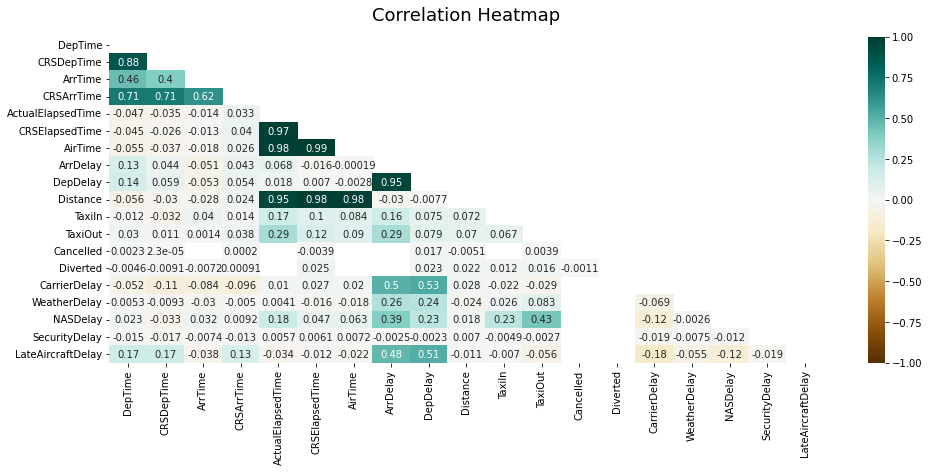

In [5]:
# Correlation Heatmap between features
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

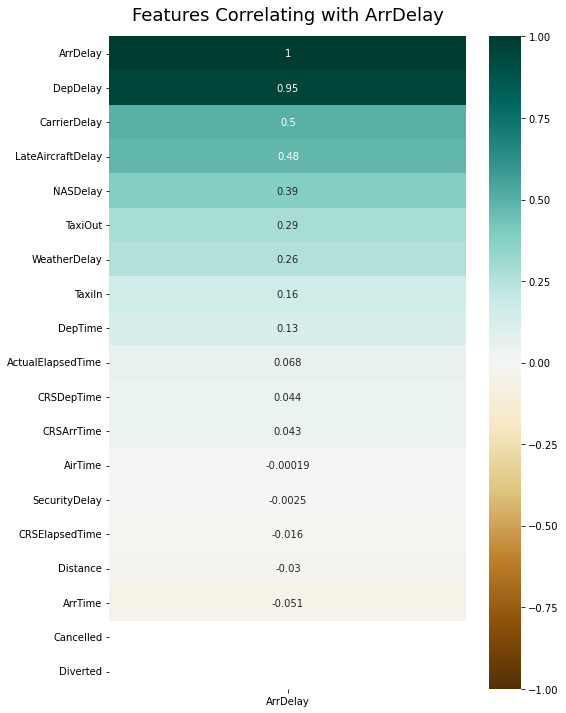

In [6]:
# Correlation of features with target ArrDelay (sorted)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['ArrDelay']].sort_values(by='ArrDelay', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with ArrDelay', fontdict={'fontsize':18}, pad=16);

Veiem que sempre que el vol ha estat cancel·lat (Cancelled==True) o Desviat (Diverted==True) la variable target ArrDelay no està definida (ArrDelay=NaN), com és lògic ja que en aquests casos el vol no arriba a destinació. Per tant podem eliminar les files que tenen Cancelled==True i Diverted==True, i les columnes Cancelled (i CancellationCode) i Diverted

In [7]:
# We check that whenever a glight is cancelled or diverted, ArrDelay is not defined (NaN)

print(f'Number of entries with Cancelled==True and non-NaN ArrDelay: {df[df.Cancelled & ~df.ArrDelay.isna()].shape[0]}')
print(f'Number of entries with Diverted==True and non-NaN ArrDelay: {df[df.Diverted & ~df.ArrDelay.isna()].shape[0]}')

# Therefore we can remove:
# - samples (rows) where Cancelled=True or Diverted=True
# - features (columns) Cancelled, CancellationCode and Diverted

df.drop(df[df.Cancelled  | df.Diverted].index, inplace=True)
df.drop(columns=['Cancelled', 'CancellationCode', 'Diverted'], inplace=True)

Number of entries with Cancelled==True and non-NaN ArrDelay: 0
Number of entries with Diverted==True and non-NaN ArrDelay: 0


Veiem que ArrDelay està fortament correlacionat amb DepDelay (un vol que surt d'origen amb retard és molt probable que arribi a destinació amb retard també). També està bastant correlacionat amb les altres variables de retard (CarrierDelay, LateAircraftDelay, etc) com és lògic. De fet ArrDelay és simplement la suma de tots aquests retards:

$ArrDelay = CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay$

In [8]:
# Checking that ArrDelay - (CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay)
# is always 0 (or NaN when not defined)
foo = df.CarrierDelay + df.WeatherDelay + df.NASDelay + df.SecurityDelay + df.LateAircraftDelay - df.ArrDelay
foo.value_counts(dropna=False)

0.0    1247488
NaN     680883
dtype: int64

D'altra banda, en una situació real, lo interessant seria poder predir quin serà el retard d'arribada **ABANS** que el vol arribi a destinació. Per tant abans de coneixer els valors de CarrierDelay, WeatherDelay, ArrTime, etc. Per això proposem  crear un model només a partir de les variables que es coneixen en el moment en que l'avió s'enlaira i abans que aterri:
Month, DayOfMonth, DayOfWeek, DepTime, DepDelay, CRSDepTime, CRSArrTime, UniqueCarrier, TailNum, CRSElapsedTime, Origin, Dest, Distance, TaxiOut.

D'altra banda, donada la relació:  

$DepDelay = DepTime - CRSDepTime$

podem eliminar una de les dues variables. Eliminem CRSDepTime.


Revisem si hi ha missing values:

In [9]:
# Checking missing values
df.isna().sum()

Month                     0
DayOfMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                   0
CRSArrTime                0
UniqueCarrier             0
TailNum                   3
ActualElapsedTime         0
CRSElapsedTime            0
AirTime                   0
ArrDelay                  0
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
CarrierDelay         680883
WeatherDelay         680883
NASDelay             680883
SecurityDelay        680883
LateAircraftDelay    680883
dtype: int64

Veiem que només hi ha 3 NaN a la columna TailNum. Eliminem aquestes 3 files.

In [10]:
# Removing 3 rows that have TailNum = NaN
df.drop(df[df.TailNum.isna()].index, inplace=True)

In [11]:
# We create binary target variable 'IsDelayed' and remove 'ArrDelay'
df['IsDelayed'] = df['ArrDelay'] > 0
df['IsDelayed'] = df['IsDelayed'].astype(int)  # To convert booleans into 0/1

El data set queda així:

In [12]:
features = ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay', 'CRSArrTime', 'UniqueCarrier', 'TailNum', 'CRSElapsedTime', 'Origin', 'Dest', 'Distance', 'TaxiOut']
target = ['IsDelayed']

df = df[features+target]

In [13]:
display(df.head())
print(f'Number of columns: {df.shape[1]}')
print(f'Number of rows: {df.shape[0]}')
print(f'Features: {features}')
print(f'Target: {target}')

,Month,DayOfMonth,DayOfWeek,DepTime,DepDelay,CRSArrTime,UniqueCarrier,TailNum,CRSElapsedTime,Origin,Dest,Distance,TaxiOut,IsDelayed
0,1,3,4,2003.0,8.0,2225,WN,N712SW,150.0,IAD,TPA,810,8.0,0
1,1,3,4,754.0,19.0,1000,WN,N772SW,145.0,IAD,TPA,810,10.0,1
2,1,3,4,628.0,8.0,750,WN,N428WN,90.0,IND,BWI,515,17.0,1
4,1,3,4,1829.0,34.0,1925,WN,N464WN,90.0,IND,BWI,515,10.0,1
5,1,3,4,1940.0,25.0,2110,WN,N726SW,115.0,IND,JAX,688,10.0,1


Number of columns: 14
Number of rows: 1928368
Features: ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay', 'CRSArrTime', 'UniqueCarrier', 'TailNum', 'CRSElapsedTime', 'Origin', 'Dest', 'Distance', 'TaxiOut']
Target: ['IsDelayed']


### Models de classificació

In [14]:
# We split the features in 2 groups, depending on the preprocessing to be performed
# At this moment we consider Month, Day, DayOfWeek as numerical features (not categorical)

# Categorical features
cat_columns = ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']

# Numerical features (all the rest)
num_columns = ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay',
               'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']

target_column = ['IsDelayed']

print(f"Categorical columns are: {cat_columns}")
print(f"Numerical columns are: {num_columns}")
print(f"Target column is: {target_column}")

Categorical columns are: ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']
Numerical columns are: ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'DepDelay', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']
Target column is: ['IsDelayed']


Definim 2 preprocessats diferents segons el tipus de variable.

In [15]:
# Preprocessing/Transformations steps for the pipelines

# Transformations for numerical features:
#   - StandardScaler()
num_pipe = Pipeline([('scaler', StandardScaler())])

# Transformations for categorical features
#   - One Hot Encoding
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

# We combine both transformations
preprocessor = ColumnTransformer(transformers=[
                                               ('num_transf', num_pipe, num_columns),
                                               ('cat_transf', cat_pipe, cat_columns)
                                               ],
                                 verbose=False)

# For some models, the target needs to be a 1D array (not a 2D array).
# So we create this transformation to convert to 1D and we will use it when needed
reshape1D_transf = FunctionTransformer(np.ravel)

Definim 4 models de regressió usant Pipelines i incloent l'etapa de preprocessament. En la majoria de casos deixem els valors de hiperparametres definits per defecte. 

In [25]:
# Note we use a different preprocessing step in each model (we clone the first preprocessor)
# so that we can train each model with different training set sizes. Otherwise, if we share
# the same preprocessing (which is the optimal way) but the training sets are different,
# the number of features after OHE is different and we get errors on matrix sizes, etc.

# Decision Tree
dt_pipeline = Pipeline([
                        ('preprocess', preprocessor), 
                        ('decision_tree', DecisionTreeClassifier(random_state=RS))
                       ])

knn_pipeline = Pipeline([
                        ('preprocess', clone(preprocessor)),
                        ('knn', TransformedTargetRegressor(regressor=KNeighborsClassifier(n_jobs=-1),
                                                           transformer=reshape1D_transf, 
                                                           check_inverse=False))
                       ])

# Logistic Regression
lr_pipeline = Pipeline([
                        ('preprocess', clone(preprocessor)), 
                        ('logistic_regression', TransformedTargetRegressor(regressor=LogisticRegression(max_iter=200,random_state=RS, n_jobs=-1),
                                                           transformer=reshape1D_transf, 
                                                           check_inverse=False))
                       ])

# SVM
svm_pipeline = Pipeline([
                        ('preprocess', clone(preprocessor)), 
                        ('svm', TransformedTargetRegressor(regressor=SVC(random_state=RS),
                                                           transformer=reshape1D_transf, 
                                                           check_inverse=False))
                       ])

# List of models
models = [dt_pipeline, knn_pipeline, lr_pipeline, svm_pipeline]


## Exercici 2
Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

### Undersampling:

Separem el dataset en dos: Training set i Test set (no fem servir Validation set perquè tampoc farem un ajust fi dels hiperparametres).

Abans, però, observem que hi ha moltissimes més mostres de la classe IsDelayed=1 que de la classe IsDelayed=0. El dataset està desbalancejat cosa que és un problema al moment d'entrenar i d'evaluar el model. Com que el dataset és molt gran, utilitzarem el mètode de submostrejar (undersampling) la classe més freqüent.

In [17]:
total_flights = df.shape[0]
flights_delayed = df[df.IsDelayed==1].shape[0]
flights_not_delayed = df[df.IsDelayed==0].shape[0] 

print(f'Number of flights delayed (class IsDelayed=1): {flights_delayed} ({100*flights_delayed/total_flights:.2f}%)')
print(f'Number of flights not delayed (class IsDelayed=0): {flights_not_delayed} ({100*flights_not_delayed/total_flights:.2f}%)')

Number of flights delayed (class IsDelayed=1): 1723412 (89.37%)
Number of flights not delayed (class IsDelayed=0): 204956 (10.63%)


In [18]:
# Undersampling the majority class (IsDelayed=1)

shuffled_df = df.sample(frac=1,random_state=RS)
not_delayed_df = shuffled_df.loc[shuffled_df['IsDelayed'] == 0]
delayed_df = shuffled_df.loc[shuffled_df['IsDelayed'] == 1].sample(n=not_delayed_df.shape[0],random_state=RS)
balanced_df = pd.concat([not_delayed_df, delayed_df])

In [19]:
# Checking the new dataset 
total_flights = balanced_df.shape[0]
flights_delayed = balanced_df[balanced_df.IsDelayed==1].shape[0]
flights_not_delayed = balanced_df[balanced_df.IsDelayed==0].shape[0] 

print(f'Number of flights (total): {total_flights}')
print(f'Number of flights delayed (class IsDelayed=1): {flights_delayed} ({100*flights_delayed/total_flights:.2f}%)')
print(f'Number of flights not delayed (class IsDelayed=0): {flights_not_delayed} ({100*flights_not_delayed/total_flights:.2f}%)')

Number of flights (total): 409912
Number of flights delayed (class IsDelayed=1): 204956 (50.00%)
Number of flights not delayed (class IsDelayed=0): 204956 (50.00%)


### Train-test splitting i entrenament dels models:

In [20]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(balanced_df[features], balanced_df[target], test_size=0.3, random_state=RS, shuffle=True, stratify=balanced_df[target])

total_size = balanced_df.shape[0]
train_size = df_X_train.shape[0]
test_size = df_X_test.shape[0]

print(f'Total size of the dataset: {total_size} samples')
print(f'Check of training set size: {train_size} samples ({100*train_size/total_size:.2f}%)')
print(f'Check of test set size: {test_size} samples ({100*test_size/total_size:.2f}%)')

Total size of the dataset: 409912 samples
Check of training set size: 286938 samples (70.00%)
Check of test set size: 122974 samples (30.00%)


Per no repetir codi (DRY) en els següents exercicis, creem 2 funcions:
- **train_test_models** per entrenar tots els models usant el Training Set (mostrejat si és massa gran) i evaluar-lo sobre el Test Set (sencer). 
- **plot_predictions** per a poder veure visualment (gràficament) uns quants valors reals de IsDelayed i les prediccions corresponents per a cada model (previament entrenat). Important: usant *random_state=None* cada cop que executem la funció dibuixa N mostres aleatòries, altrament sempre dibuixarà les mateixes mostres.

In [21]:
def train_test_models(models, df_X_train, df_y_train, df_X_test, df_y_test, train_size=None):
  '''
  Trains all the models (pipelines) in the list "models" using a training set
  and evaluates them using a test set

  Parameters:
    - models: list of models (pipelines) to fit (train)
    - df_X_train and df_y_train: DataFrames (training set) of features and target (isDelayed)
    - train_size: number of samples to use for training, picked using random sampling.
      · 'None' to use the full training set (i.e. without sampling)
      · Integer to use the same sample size for all models
      · List of Integers to use a different sample size for each model
    - verbose: True to show the progress for debugging (i.e. which models is being processed at each moment)
  
  Returns:
    - models: trained models
    - train_indices: indices of the samples used for training (in case of not using the full training set)
    - train_metrics: dictionary containing MSE and R2 metrics computed on the 
      (sampled) training set. Includes also the training time.
    - test_metrics: dictionary containing MSE and R2 metrics computed on the full test set
  
  Prints:
    - the returned data printed in tabular format
  '''
  
  # Sampling of the training set ('None' for no-sampling i.e. full training set)
  if train_size == None:
    train_indices = [df_X_train.index.to_list()] * len(models)
  elif isinstance(train_size, int):
    train_indices = [df_X_train.sample(train_size, random_state=RS).index.to_list()] * len(models)
  elif isinstance(train_size, list):
    train_indices = list()
    for i, size in enumerate(train_size):
      if size == None:
        train_indices.append(df_X_train.index.to_list())
      else:
        train_indices.append(df_X_train.sample(size, random_state=RS).index.to_list())

  # We iterate over the list of models, showing a progress bar (TQDM)
  for i, model in enumerate(tqdm(models)):  
    print(f"Model: {model.steps[-1][0]}. Training size: {len(train_indices[i])} samples. ", end='')

    X = df_X_train.loc[train_indices[i],:]
    y = df_y_train.loc[train_indices[i],:]
    # Model training (fitting)
    start = time.time()
    model.fit(X, y)
    stop = time.time()
    training_time = stop-start
    print(f"Training time: {training_time:.2f} seconds. ", end='')

    # Metrics evaluated on the full test set
    start = time.time()
    y_pred_test = model.predict(df_X_test)
    stop = time.time()
    test_time = stop-start
    print(f"Test time: {test_time:.2f} seconds.\n")
    print(classification_report(df_y_test, y_pred_test))
    print(f"-----------------------------------------------------\n")
  
  return models, train_indices


In [22]:
def plot_confusion_matrix(trained_models, df_X_test, df_y_test):
  '''
  Plots the confusion matrix of all models

  Parameters:
    - trained_models: list of models (pipelines) already trained
    - df_X_test and df_y_test: DataFrames of features (X) and target IsDelayed (y)
  
  Plots:
    - the confusion matrices of each model
  '''

  f, axes = plt.subplots(1, len(trained_models), figsize=(25, 5), sharey='row')

  for i, model in enumerate(tqdm(trained_models)):
      model_name = model.steps[-1][0]
      y_pred = model.predict(df_X_test)
      cf_matrix = confusion_matrix(df_y_test, y_pred)
      disp = ConfusionMatrixDisplay(cf_matrix, display_labels=[0,1])
      disp.plot(ax=axes[i], values_format='')
      disp.ax_.set_title(f'Model: {model_name}')
      disp.im_.colorbar.remove()

  plt.subplots_adjust(wspace=0.40, hspace=0.1)

  f.colorbar(disp.im_, ax=axes)
  plt.suptitle("Confusion matrices for 'IsDelayed'")
  plt.show()

In [26]:
models, indices_train = train_test_models(models, 
                                                df_X_train, df_y_train, 
                                                df_X_test, df_y_test, train_size=10_000)

  0%|          | 0/4 [00:00<?, ?it/s]

Model: decision_tree. Training size: 10000 samples. Training time: 0.93 seconds. Test time: 0.43 seconds.

              precision    recall  f1-score   support

           0       0.80      0.84      0.82     61487
           1       0.83      0.79      0.81     61487

    accuracy                           0.81    122974
   macro avg       0.81      0.81      0.81    122974
weighted avg       0.81      0.81      0.81    122974

-----------------------------------------------------

Model: knn. Training size: 10000 samples. Training time: 0.05 seconds. Test time: 84.94 seconds.

              precision    recall  f1-score   support

           0       0.67      0.80      0.73     61487
           1       0.76      0.61      0.68     61487

    accuracy                           0.71    122974
   macro avg       0.71      0.71      0.70    122974
weighted avg       0.71      0.71      0.70    122974

-----------------------------------------------------

Model: logistic_regression. Tra

  0%|          | 0/4 [00:00<?, ?it/s]

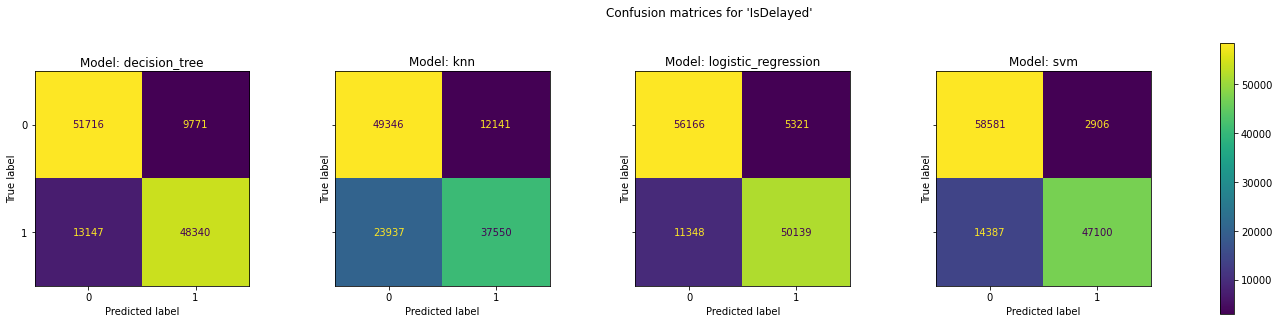

In [27]:
plot_confusion_matrix(models, df_X_test, df_y_test)

Observacions:
- L'accuracy del model KNN és significativament inferior al dels altres models. Com que el dataset està balancejat, Accuracy és un bon indicador per evaluar i comparar els models.
- Dels quatre models, el que té millor accuracy és Logistic Regression i SVM (0.86)
- Veiem a les matrius de confusió que els models tenen més tendència a classificar malament els vols amb retard (IsDelayed=1) que els que no tenen retard. En efecte en tots els models, la classe 0 té un Recall més gran que la classe 1 però una Precisió més petita.

## Exercici 3
Entrena’ls utilitzant els diferents paràmetres que admeten.

Intentarem millorar el resultat modificant alguns dels paràmetres que permet cada model. Fem una còpia utilitzant "clone" per no sobreescriure els models que ja hem entrenat.

In [47]:
# "Clone" does a deep copy of the model in an estimator without actually copying attached data. 
# It yields a new estimator with the SAME parameters that has NOT been fitted on any data.
models2 = clone(models)

# We try new values for the hyperparameters of each model
#[dt_pipeline, knn_pipeline, lr_pipeline, svm_pipeline]

# DecistionTree - models2[0]
models2[0].set_params(decision_tree__max_depth=None,
                      decision_tree__max_features='log2');

# KNN - models2[1]
models2[1].set_params(knn__regressor__n_neighbors=7);

# Logistic Regression - models2[2]
models2[2].set_params(logistic_regression__regressor__penalty='l1',
                      logistic_regression__regressor__solver='saga')

# SVM - models2[3]
models2[3].set_params(svm__regressor__kernel='rbf',
                      svm__regressor__gamma='auto');



In [48]:
models2, indices_train = train_test_models(models2, 
                                                df_X_train, df_y_train, 
                                                df_X_test, df_y_test, train_size=[10_000, 10_000, 10_000, 10_000])

  0%|          | 0/4 [00:00<?, ?it/s]

Model: decision_tree. Training size: 10000 samples. Training time: 0.19 seconds. Test time: 0.50 seconds.

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     61487
           1       0.64      0.63      0.63     61487

    accuracy                           0.63    122974
   macro avg       0.63      0.63      0.63    122974
weighted avg       0.63      0.63      0.63    122974

-----------------------------------------------------

Model: knn. Training size: 10000 samples. Training time: 0.07 seconds. Test time: 103.36 seconds.

              precision    recall  f1-score   support

           0       0.68      0.83      0.74     61487
           1       0.78      0.61      0.68     61487

    accuracy                           0.72    122974
   macro avg       0.73      0.72      0.71    122974
weighted avg       0.73      0.72      0.71    122974

-----------------------------------------------------

Model: logistic_regression. Tr

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Training time: 5.27 seconds. Test time: 0.41 seconds.

              precision    recall  f1-score   support

           0       0.83      0.93      0.87     61487
           1       0.92      0.80      0.86     61487

    accuracy                           0.87    122974
   macro avg       0.87      0.87      0.87    122974
weighted avg       0.87      0.87      0.87    122974

-----------------------------------------------------

Model: svm. Training size: 10000 samples. Training time: 6.88 seconds. Test time: 59.99 seconds.

              precision    recall  f1-score   support

           0       0.65      0.98      0.78     61487
           1       0.97      0.47      0.63     61487

    accuracy                           0.72    122974
   macro avg       0.81      0.72      0.71    122974
weighted avg       0.81      0.72      0.71    122974

-----------------------------------------------------



Veiem que en base a l'Accuracy, hem millorat lleugerament els models de KNN i LogisticRegression però ha empitjorat la resta.

  0%|          | 0/4 [00:00<?, ?it/s]

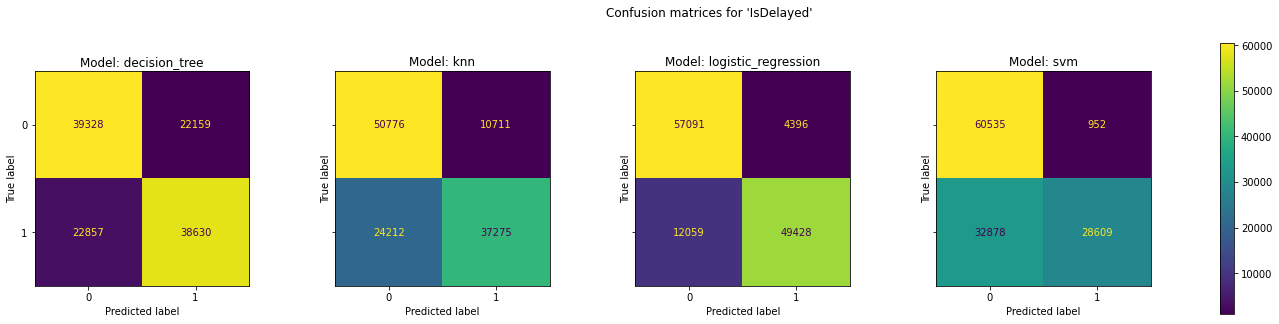

In [49]:
plot_confusion_matrix(models2, df_X_test, df_y_test)

## Exercici 4
Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

L'aproximació train/test és la que hem utilitzat en els exercicis anteriors.
Aquí utilitzarem CrossValidation per entrenar i evaluar cada model.

In [50]:
def crossvalidate_models(models, df_X_train, df_y_train, sample_size=None, cv=3):
  '''
  Trains all the models (pipelines) in the list "models" using a training set
  and evaluates them using a test set

  Parameters:
    - models: list of models (pipelines) to fit (train)
    - df_X_train and df_y_train: DataFrames (training set) of features and target (isDelayed)
    - train_size: number of samples to use for training, picked using random sampling.
      · 'None' to use the full training set (i.e. without sampling)
      · Integer to use the same sample size for all models
      · List of Integers to use a different sample size for each model
    - verbose: True to show the progress for debugging (i.e. which models is being processed at each moment)
  
  Prints:
    - the average metrics for each model for all the k-folds
  '''

  #Make our customer score
  def cv_classification_report(y_true, y_pred):
    y_true = y_true.to_numpy()
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

  # Sampling of the training set ('None' for no-sampling i.e. full training set)
  if sample_size == None:
    idxs = [df_X_train.index.to_list()] * len(models)
  elif isinstance(sample_size, int):
    idxs = [df_X_train.sample(sample_size, random_state=RS).index.to_list()] * len(models)
  elif isinstance(sample_size, list):
    idxs = list()
    for i, size in enumerate(sample_size):
      if size == None:
        idxs.append(df_X_train.index.to_list())
      else:
        idxs.append(df_X_train.sample(size, random_state=RS).index.to_list())

  # We iterate over the list of models, showing a progress bar (TQDM)
  for i, model in enumerate(tqdm(models)):
    # Variables for average classification report
    originalclass = []
    predictedclass = []

    print(f"Model: {model.steps[-1][0]}. Total sample size: {len(idxs[i])} samples." )

    X = df_X_train.loc[idxs[i],:]
    y = df_y_train.loc[idxs[i],:]

    # Cross validation
    #score = cross_validate(model, X, y, cv=cv)

    _ = cross_validate(model, X, y, cv=cv, scoring=make_scorer(cv_classification_report))

    print(classification_report(originalclass, predictedclass))

    print(f"-----------------------------------------------------\n")
  
  return models


Fem una còpia dels models (amb els paràmetres de l'exercici 2) per no sobreescriure'ls quan fem el cross-validation.

In [57]:
# "Clone" does a deep copy of the model in an estimator without actually copying attached data. 
# It yields a new estimator with the SAME parameters that has NOT been fitted on any data.
models3 = clone(models)

In [58]:
# models3 = crossvalidate_models(models3, df_X_train, df_y_train, cv=3)
models3 = crossvalidate_models(models3, balanced_df[features], balanced_df[target], cv=3, sample_size=120_000)

  0%|          | 0/4 [00:00<?, ?it/s]

Model: decision_tree. Total sample size: 120000 samples.
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     59921
           1       0.84      0.81      0.82     60079

    accuracy                           0.83    120000
   macro avg       0.83      0.83      0.83    120000
weighted avg       0.83      0.83      0.83    120000

-----------------------------------------------------

Model: knn. Total sample size: 120000 samples.
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     59921
           1       0.78      0.64      0.70     60079

    accuracy                           0.73    120000
   macro avg       0.74      0.73      0.73    120000
weighted avg       0.74      0.73      0.73    120000

-----------------------------------------------------

Model: logistic_regression. Total sample size: 120000 samples.
              precision    recall  f1-score   support

           0  

Obtenim mètriques similars a les que hem tingut fent train/test.

## Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

In [82]:
# Copy of the original training dataframe
df2_X_train = df_X_train.copy()

# We find the non-outliers using the Zscore method and get the indices of the rows
idx = df2_X_train.loc[(np.abs(stats.zscore(df2_X_train[num_columns])) < 3).all(axis=1)].index

In [83]:
# Filtered dataframes (without outliers)
df2_X_train = df2_X_train.loc[idx,:]
df2_y_train = df_y_train.loc[idx,:]

In [79]:
# We train again the models with the same parameters as in exercices 1 and 2
# but using the new training dataset
models4 = clone(models)
models4, indices_train = train_test_models(models4, 
                                                df2_X_train, df2_y_train, 
                                                df_X_test, df_y_test, train_size=10_000)

  0%|          | 0/4 [00:00<?, ?it/s]

Model: decision_tree. Training size: 10000 samples. Training time: 0.83 seconds. Test time: 0.44 seconds.

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     61487
           1       0.80      0.80      0.80     61487

    accuracy                           0.80    122974
   macro avg       0.80      0.80      0.80    122974
weighted avg       0.80      0.80      0.80    122974

-----------------------------------------------------

Model: knn. Training size: 10000 samples. Training time: 0.05 seconds. Test time: 103.45 seconds.

              precision    recall  f1-score   support

           0       0.72      0.84      0.78     61487
           1       0.81      0.68      0.74     61487

    accuracy                           0.76    122974
   macro avg       0.77      0.76      0.76    122974
weighted avg       0.77      0.76      0.76    122974

-----------------------------------------------------

Model: logistic_regression. Tr

Veiem que eliminant els outliers hem millorat significativament la preficció del model KNN tot i que la dels altres models no ha canviat o ha empitjorat lleurgerament.

## Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions.

In [85]:
# We clone the model from exercises 1 and 2
models5 = clone(models)

In [87]:
# We split the features in 2 groups, depending on the preprocessing to be performed
# At this moment we consider Month, Day, DayOfWeek as numerical features (not categorical)

# Categorical features
cat_columns5 = ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']

# Numerical features (all the rest). Note that "DepDelay" has been removed
num_columns5 = ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 
               'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']

target_column5 = ['IsDelayed']

print(f"Categorical columns are: {cat_columns5}")
print(f"Numerical columns are: {num_columns5}")
print(f"Target column is: {target_column5}")

Categorical columns are: ['TailNum', 'UniqueCarrier', 'Dest', 'Origin']
Numerical columns are: ['Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'TaxiOut']
Target column is: ['IsDelayed']


In [88]:
# Preprocessing/Transformations steps for the pipelines

# Transformations for numerical features:
#   - StandardScaler()
num_pipe5 = Pipeline([('scaler', StandardScaler())])

# Transformations for categorical features
#   - One Hot Encoding
cat_pipe5 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

# We combine both transformations
preprocessor5 = ColumnTransformer(transformers=[
                                               ('num_transf', num_pipe5, num_columns5),
                                               ('cat_transf', cat_pipe5, cat_columns5)
                                               ],
                                 verbose=False)

# For some models, the target needs to be a 1D array (not a 2D array).
# So we create this transformation to convert to 1D and we will use it when needed
reshape1D_transf = FunctionTransformer(np.ravel)

In [89]:
# We replace the preprocessing part in all models
for model in models5:
  model.steps.pop(0);
  model.steps.insert(0,['preprocess5', preprocessor5])

In [91]:
# We drop the "DepDelay" column in both training and test sets
df_X_train5 = df_X_train.drop(columns=['DepDelay'])
df_X_test5 = df_X_test.drop(columns=['DepDelay'])

In [92]:
models5, indices_train = train_test_models(models5, 
                                                df_X_train5, df_y_train, 
                                                df_X_test5, df_y_test, train_size=10_000)

  0%|          | 0/4 [00:00<?, ?it/s]

Model: decision_tree. Training size: 10000 samples. Training time: 0.86 seconds. Test time: 0.47 seconds.

              precision    recall  f1-score   support

           0       0.65      0.66      0.65     61487
           1       0.65      0.64      0.64     61487

    accuracy                           0.65    122974
   macro avg       0.65      0.65      0.65    122974
weighted avg       0.65      0.65      0.65    122974

-----------------------------------------------------

Model: knn. Training size: 10000 samples. Training time: 0.05 seconds. Test time: 99.47 seconds.

              precision    recall  f1-score   support

           0       0.61      0.68      0.64     61487
           1       0.64      0.57      0.60     61487

    accuracy                           0.62    122974
   macro avg       0.63      0.62      0.62    122974
weighted avg       0.63      0.62      0.62    122974

-----------------------------------------------------

Model: logistic_regression. Tra

  0%|          | 0/4 [00:00<?, ?it/s]

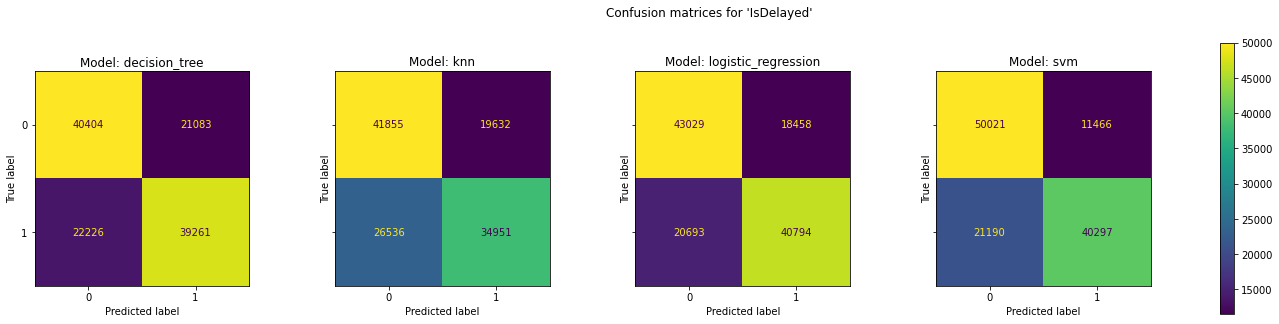

In [93]:
plot_confusion_matrix(models5, df_X_test5, df_y_test)

Veiem com amb els mateixos models amb els mateixos hiperparàmetres però entrenats sense la variable 'DepDelay' no s'obtenen bones prediccions. Es podria intentar millorar les prediccions ajustant els hiperparàmetres però ja es veu que no es podrà arribar a un resultat tant bo, ja que la variable DepDelay està fortament correlacionada amb el target ArrDelay i per tant amb IsDelayed. En efecte, té sentit pensar que un retard en la sortida té un fort impacte en el retard a l'arribada.